# System

In [2]:
import os
os.getcwd()

'c:\\Users\\ataheimer\\OneDrive - Kocaeli Universitesi Uzaktan Egitim Merkezi\\Masaüstü\\Derin Öğrenme\\Garbage classification'

# Libraries

In [1]:
import numpy as np
import pandas as pd
from imutils import paths

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
import time
import copy
from random import shuffle

import tqdm.notebook as tqdm

import sklearn
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from PIL import Image
import cv2

import os
import shutil

In [2]:
# CUDA kullanılabilir mi kontrol et
if torch.cuda.is_available():
    # CUDA cihazlarını listele
    for i in range(torch.cuda.device_count()):
        print(f"CUDA Device {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA destekli bir GPU bulunamadı.")

CUDA Device 0: NVIDIA GeForce RTX 4060 Laptop GPU


# GPU

In [3]:
# setting device on GPU if available, else CPU
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device("cuda")
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce RTX 4060 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [4]:
if torch.cuda.is_available():
    device=torch.device("cuda:0")
    print("Training on GPU... Ready for HyperJump...")
else:
    device = torch.device("cpu")
    print("Training on CPU... May the force be with you...")

Training on GPU... Ready for HyperJump...


# PATHS

In [5]:
dir_path = "Garbage classification"

# Plotting Distribution of Each Classes

In [6]:
target_size = (224,224)

waste_labels = {"cardboard": 0, "glass": 1, "metal": 2, "paper": 3, "plastic": 4, "trash": 5}

# Plotting Distribution of Train Classes

In [9]:
def load_datasets(path):
  """
  Görsellerin bulunduğu dizindeki görüntüyü okuyup etiketlerini oluşturur.

  Parametreler:

  path: Görsellerin bulunduğu dizini ifade eder.

  Return:

  x: Görüntülere ait matris bilgilerini tutar.

  labels: Görüntünün ait olduğu sınıf bilgisini tutan liste
  """

  x = []
  labels = []

  # Gönderdiğimiz pathdeki görüntüleri listeleyip sıralamaktadır.
  image_paths = sorted(list(paths.list_images(path)))

  for image_path in image_paths:
    #Belirtilen pathdeki görüntüler openCV kütüphanesi ile okunmaktadır.
    img = cv2.imread(image_path)

    #Okunan görüntüler başlangıçta belirlenen target_size'a göre yeniden ölçeklendirilir.
    img = cv2.resize(img, target_size)

    #Ölçeklendirilen görüntüler x listesine eklenir.
    x.append(img)

    #Her bir path '/' ifadesi ile ayrıldığında dönen listenin sondan ikinci elemanı labelı temsil etmektedir.
    label = image_path.split(os.path.sep)[-2]

    #Yakalanan labelların sayısal değer karşılıklarının olduğu waste_labels sözlüğü içerisinden gönderilern key
    #değerine karşılık value değeri alınarak label oluşturulur.
    labels.append(waste_labels[label])

  # Veri seti random bir şekilde karıştırılır.
  x, labels = shuffle(x, labels, random_state = 42)

  # Boyut ve sınıf bilgisi raporlanmaktadır.
  print(f"X boyutu: {np.array(x).shape}")
  print(f"Label sınıf sayısı: {len(np.unique(labels))} Gözlem sayısı: {len(labels)}")

  return x, labels

# Plotting Distribution of Test Classes

In [8]:
x, labels = load_datasets(dir_path)

X boyutu: (2527, 224, 224, 3)
Label sınıf sayısı: 6 Gözlem sayısı: 2527


# Data Loading

In [10]:
# Görüntü boyutlarının tutulması
input_shape = (np.array(x[0]).shape[1], np.array(x[0]).shape[1], 3)
print(input_shape)

(224, 224, 3)


In [11]:
def visualize_img(image_batch, label_batch):
  """

  Veriseti içerisinden görüntü görselleştirir.

  Parametreler:

  image_batch: Görüntülere ait matris bilgilerini tutar.

  label_batch: Görüntünün ait olduğu sınıf bilgilerini tutan liste.

  """

  plt.figure(figsize=(10,10))
  for n in range(10):
    ax = plt.subplot(5,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(np.array(list(waste_labels.keys()))[torch.nn.functional.one_hot(torch.tensor(labels), num_classes=6)[n]==1][0].title())
    plt.axis("off")

# Visualization of Train Samples

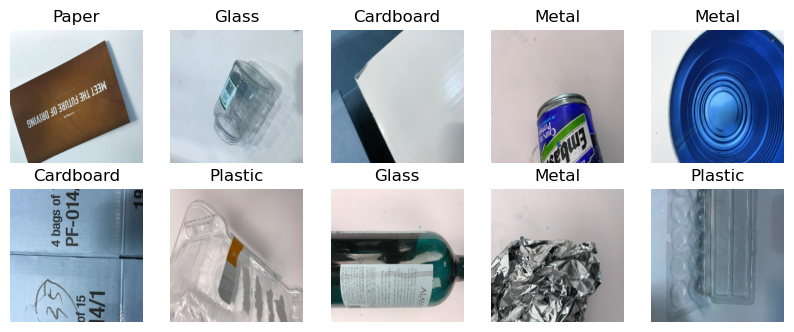

In [12]:
visualize_img(x, labels)

In [13]:
#Statistics Based on ImageNet Data for Normalisation
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

data_transforms = {"train":transforms.Compose([
                                transforms.Resize((224,224)), #Resizes all images into same dimension
                                transforms.ToTensor(), # Coverts into Tensors
                                transforms.Normalize(mean = mean_nums, std=std_nums)]), # Normalizes
                    "test": transforms.Compose([
                                transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean_nums, std = std_nums)
                    ])}


In [14]:
def load_split_train_test(datadir, valid_size = .1):
    train_data = datasets.ImageFolder(datadir,
                    transform=data_transforms['train']) #Picks up Image Paths from its respective folders and label them
    print(train_data)
    test_data = datasets.ImageFolder(datadir,
                    transform=data_transforms['test'])
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    train_idx, test_idx = indices[split:], indices[:split]
    dataset_size = {"train":len(train_idx), "val":len(test_idx)}
    train_sampler = SubsetRandomSampler(train_idx) # Sampler for splitting train and val images
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=25) # DataLoader provides data from traininng and validation in batches
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=252)
    return trainloader, testloader, dataset_size
trainloader, valloader, dataset_size = load_split_train_test(dir_path, .1)
dataloaders = {"train":trainloader, "val":valloader}
data_sizes = {x: len(dataloaders[x].sampler) for x in ['train','val']}
class_names = trainloader.dataset.classes
print(data_sizes)
print(class_names)

# Dataset has 15886 data points.
# Train Dataset has 12708 data points
# Test Dataset has 3178 data points.

Dataset ImageFolder
    Number of datapoints: 2527
    Root location: Garbage classification
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
{'train': 2275, 'val': 252}
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']



# All model variants

In [15]:
def CNN_Model(pretrained=True):
    model = models.densenet169(pretrained=pretrained) # Returns Defined Densenet model with weights trained on ImageNet
    #model = models.alexnet(pretrained=pretrained)
    model.eval()
    return model

model = CNN_Model(pretrained=True)

# specify loss function (categorical cross-entropy loss)
criterion = nn.CrossEntropyLoss()

# Specify optimizer which performs Gradient Descent
optimizer = optim.RMSprop(model.parameters(), lr=1e-3)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=429, gamma=0.1) # Learning Scheduler

c:\Users\ataheimer\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ataheimer\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

# Training

In [17]:
import math
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0
            current_kappa = 0
            val_kappa = list()

            for inputs, labels in tqdm.tqdm(dataloaders[phase], desc=phase, leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # We need to zero the gradients in the Cache.
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                if phase == 'train':
                    scheduler.step()

                # We want variables to hold the loss statistics
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)

                val_kappa.append(cohen_kappa_score(preds.cpu().numpy(), labels.data.cpu().numpy()))
                #print(val_kappa)
            epoch_loss = current_loss / data_sizes[phase]
            epoch_acc = current_corrects.double() / data_sizes[phase]
            if phase == 'val':
                epoch_kappa = np.mean(val_kappa)
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f} | Kappa Score: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc, epoch_kappa))
            else:
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc))

            # EARLY STOPPING
            if phase == 'val' and epoch_loss < best_loss:
                print('Val loss Decreased from {:.4f} to {:.4f} \nSaving Weights... '.format(best_loss, epoch_loss))
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val loss: {:.4f}'.format(best_loss))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model

In [18]:
model.cuda()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [19]:
np.seterr(divide='ignore', invalid='ignore')
base_model = train_model(model, criterion, optimizer, exp_lr_scheduler,num_epochs=10)

Epoch 1/10
----------


train:   0%|          | 0/91 [00:00<?, ?it/s]

train Loss: 1.8876 | train Accuracy: 0.3609


val:   0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 3.2890 | val Accuracy: 0.4087 | Kappa Score: 0.2776
Val loss Decreased from inf to 3.2890 
Saving Weights... 

Epoch 2/10
----------


train:   0%|          | 0/91 [00:00<?, ?it/s]

train Loss: 1.3361 | train Accuracy: 0.4985


val:   0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 1.3636 | val Accuracy: 0.4802 | Kappa Score: 0.3489
Val loss Decreased from 3.2890 to 1.3636 
Saving Weights... 

Epoch 3/10
----------


train:   0%|          | 0/91 [00:00<?, ?it/s]

train Loss: 1.2582 | train Accuracy: 0.5305


val:   0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 1.1703 | val Accuracy: 0.5556 | Kappa Score: 0.4532
Val loss Decreased from 1.3636 to 1.1703 
Saving Weights... 

Epoch 4/10
----------


train:   0%|          | 0/91 [00:00<?, ?it/s]

train Loss: 1.0616 | train Accuracy: 0.6092


val:   0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 1.1108 | val Accuracy: 0.5714 | Kappa Score: 0.4718
Val loss Decreased from 1.1703 to 1.1108 
Saving Weights... 

Epoch 5/10
----------


train:   0%|          | 0/91 [00:00<?, ?it/s]

train Loss: 0.9389 | train Accuracy: 0.6527


val:   0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.7742 | val Accuracy: 0.7262 | Kappa Score: 0.6643
Val loss Decreased from 1.1108 to 0.7742 
Saving Weights... 

Epoch 6/10
----------


train:   0%|          | 0/91 [00:00<?, ?it/s]

train Loss: 0.7278 | train Accuracy: 0.7429


val:   0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.6844 | val Accuracy: 0.7698 | Kappa Score: 0.7183
Val loss Decreased from 0.7742 to 0.6844 
Saving Weights... 

Epoch 7/10
----------


train:   0%|          | 0/91 [00:00<?, ?it/s]

train Loss: 0.6632 | train Accuracy: 0.7635


val:   0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.6370 | val Accuracy: 0.7540 | Kappa Score: 0.6993
Val loss Decreased from 0.6844 to 0.6370 
Saving Weights... 

Epoch 8/10
----------


train:   0%|          | 0/91 [00:00<?, ?it/s]

train Loss: 0.6082 | train Accuracy: 0.7855


val:   0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.6043 | val Accuracy: 0.7659 | Kappa Score: 0.7134
Val loss Decreased from 0.6370 to 0.6043 
Saving Weights... 

Epoch 9/10
----------


train:   0%|          | 0/91 [00:00<?, ?it/s]

train Loss: 0.5479 | train Accuracy: 0.8114


val:   0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.6864 | val Accuracy: 0.7421 | Kappa Score: 0.6835

Epoch 10/10
----------


train:   0%|          | 0/91 [00:00<?, ?it/s]

train Loss: 0.4785 | train Accuracy: 0.8171


val:   0%|          | 0/1 [00:00<?, ?it/s]

val Loss: 0.4927 | val Accuracy: 0.8214 | Kappa Score: 0.7824
Val loss Decreased from 0.6043 to 0.4927 
Saving Weights... 

Training complete in 4m 21s
Best val loss: 0.4927


In [20]:
torch.save(model.state_dict(), "garbage.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


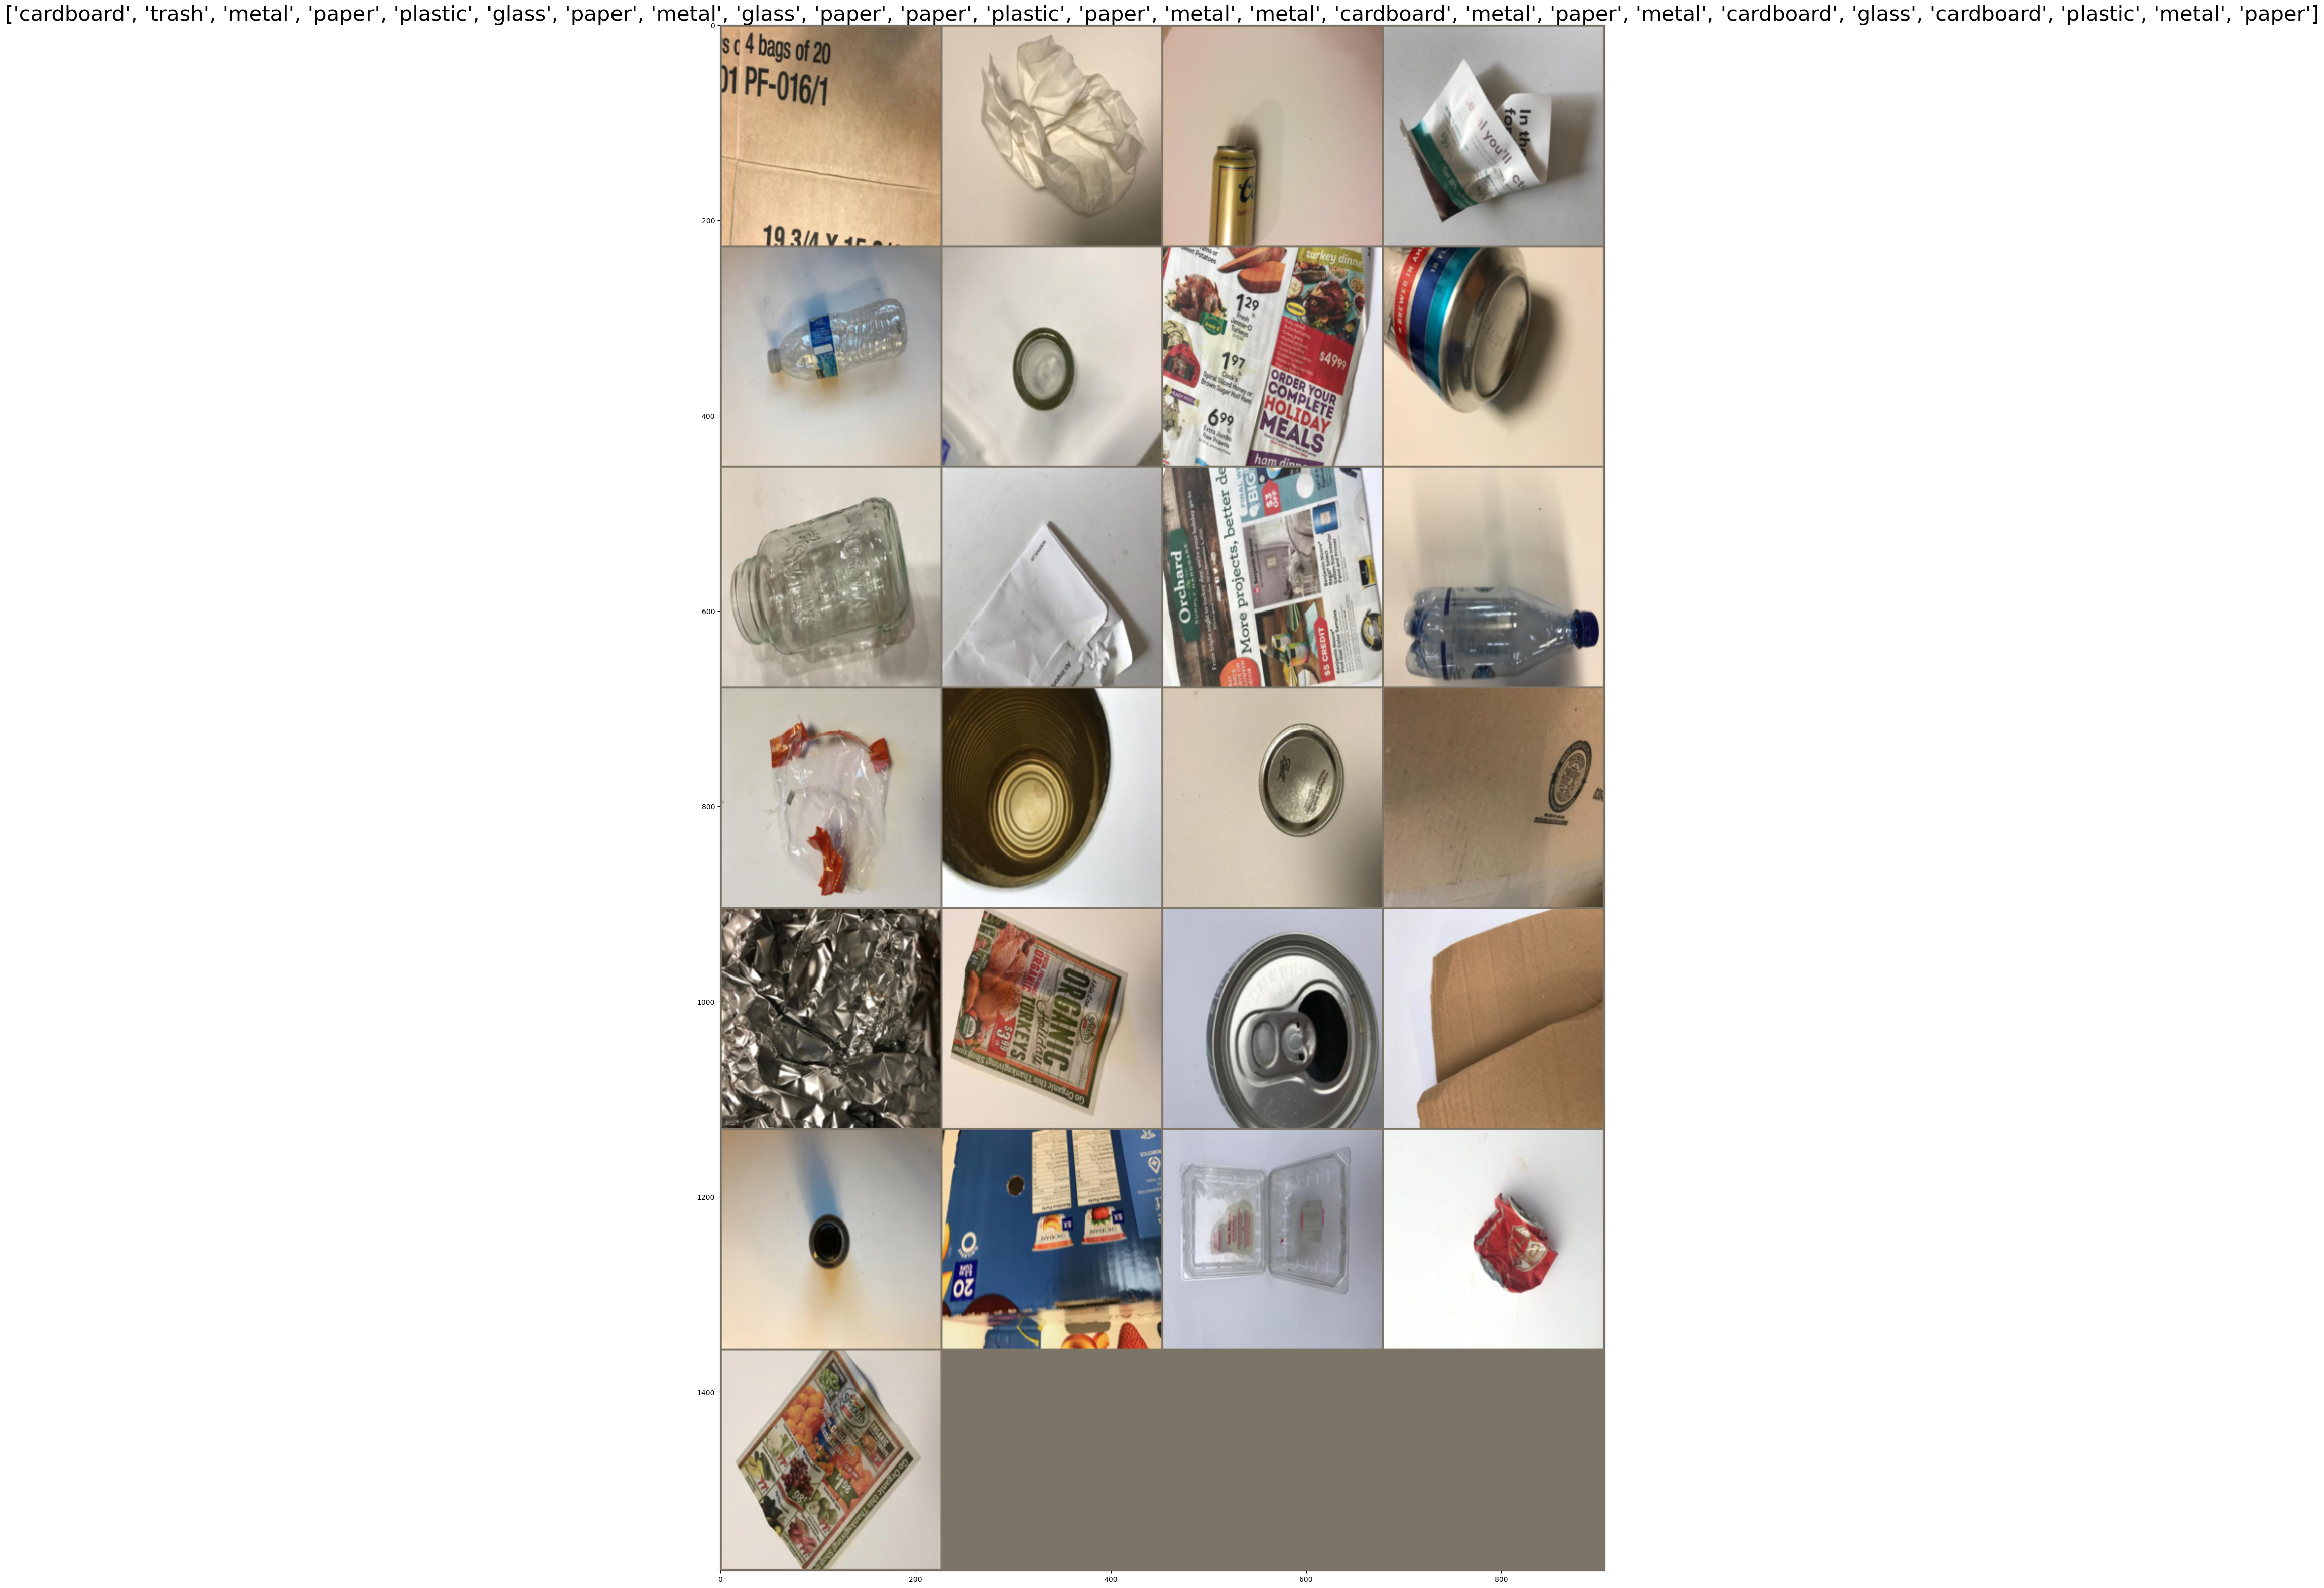

In [21]:
import matplotlib
def imshow(inp, size =(40,40), title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = mean_nums
    std = std_nums
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=size)
    plt.imshow(inp)
    if title is not None:
        plt.title(title, size=30)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data

inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow =  4, padding =  2, value_range = 1)



imshow(out, title=[class_names[x] for x in classes])


# # Get a batch of val data

# inputs, classes = next(iter(dataloaders['val']))

# # Make a grid from batch
# out = torchvision.utils.make_grid(inputs)

# imshow(out, title=[class_names[x] for x in classes])

# Model Visualization

In [22]:
def visualize_model(model, num_images=12):
    was_training = model.training
    model.eval()
    images_handeled = 0
    ax = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('Actual: {} Predicted: {}'.format(class_names[labels[j].item()],class_names[preds[j]]))
                imshow(inputs.cpu().data[j], (4,4))

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

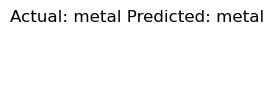

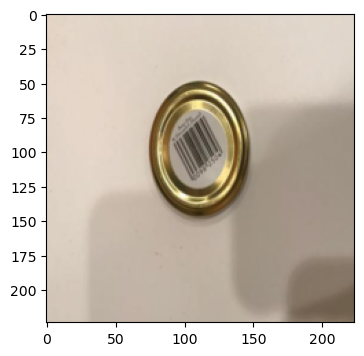

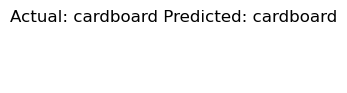

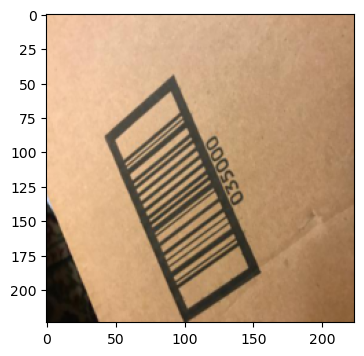

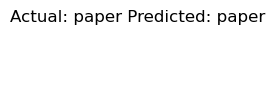

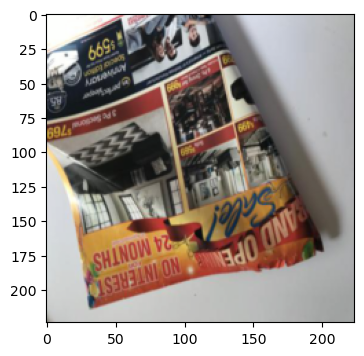

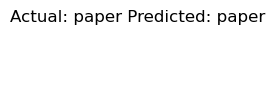

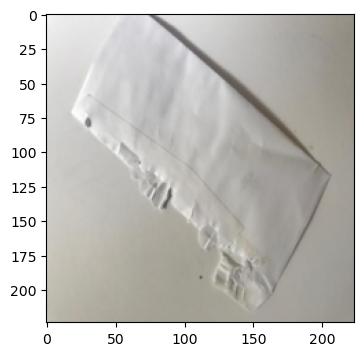

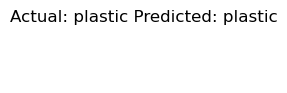

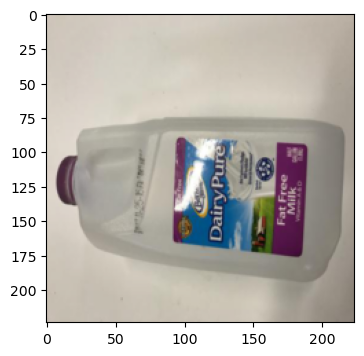

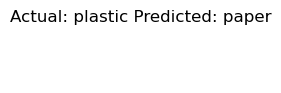

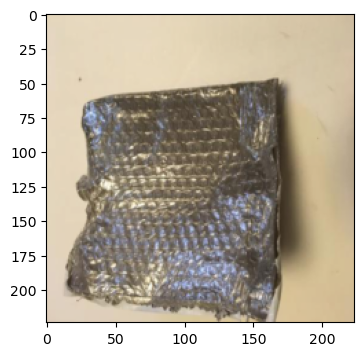

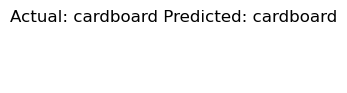

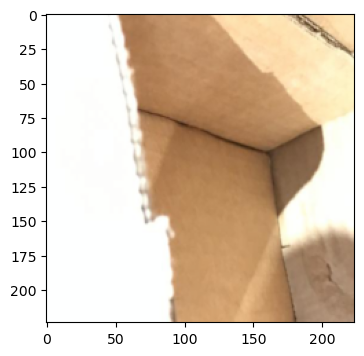

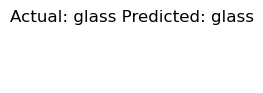

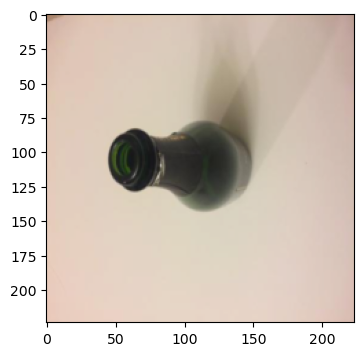

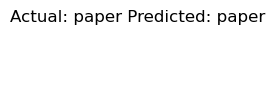

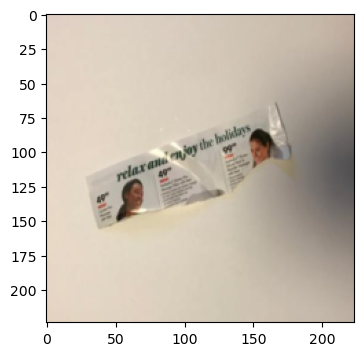

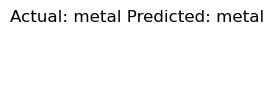

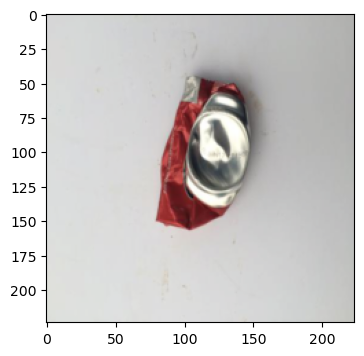

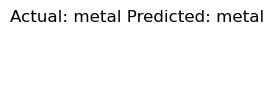

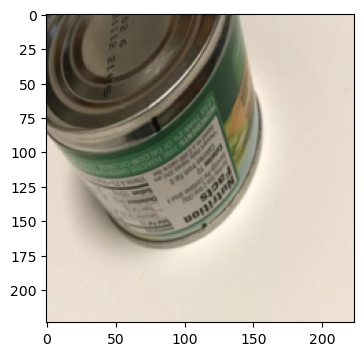

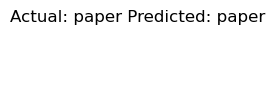

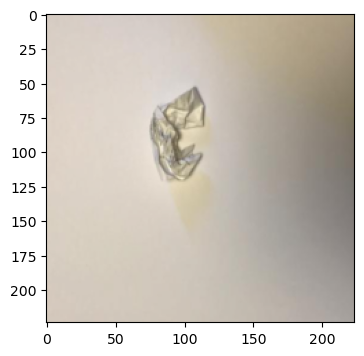

In [23]:
visualize_model(base_model)
plt.show()

# Test Accuracy

In [27]:
class_names

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [28]:
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F

def test_model(model,dataloaders,device):
    CM=0
    model.eval()
    with torch.no_grad():
        #for data in dataloaders['test']:
        i=0
        j=0
        sumtp, sumfp, sumfn, sumfp = 0, 0, 0, 0
        for data in dataloaders['val']:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images) #file_name
            preds = torch.argmax(outputs.data, 1)
            CM+=confusion_matrix(labels.cpu(), preds.cpu(),labels=[0, 1 ])

        tp=CM[1][1]
        fp=CM[0][1]
        fn=CM[1][0]
        acc=np.sum(np.diag(CM)/np.sum(CM))
        recall=sumtp/(sumtp+sumfn)
        precision=sumtp/(sumtp+sumfp)
        print('\nTestset Accuracy(mean): %f %%' % (100 * acc))
        #print('- NPV: ',(tn/(tn+fn))*100
        return acc, CM



In [29]:
acc, cm = test_model(model,dataloaders,device)
print(cm)
print("Accuracy",acc)

ZeroDivisionError: division by zero

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
class_names

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [ ]:
from sklearn import metrics
plot_confusion_matrix(cm, target_names= ['NORMAL', 'PNEUMONIA'], title='Confusion matrix' , normalize=False)

NameError: name 'cm' is not defined